# Updated Modeling

In this notebook we found out most effective model, the random forest classifier using sklearn, which resulted in a total cost of 1,218.84 per prediction, which is well below the baseline of 1,570.85 detailed in the Cost Matrix Excel workbook. We achieved this through hyperparameter tuning of all the models as well as mapping diagnosis codes to diagnosis categories and including them in the features.

Again we will credit Andrew Long's GitHub, https://github.com/andrewwlong/diabetes_readmission/blob/master/diabetes_project.ipynb, for several of the methods used along with Dennis T's Medium article for the confusion matrix visualization, https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea. 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

### Load Data

In [2]:
data = pd.read_csv('dataset_diabetes/diabetic_data.csv', na_values = '?')
data.info()

C:\Users\ssear\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      99493 non-null   object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    3197 non-null    object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                61510 non-null   object
 11  medical_specialty         51817 non-null   object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

# Data Preparation

### Update Diagnosis ID Codes

In [3]:
def convert_code(code):
    try:
        code = float(code)
        if code >= 1 and code <= 139:
            return 1
        elif code >= 140 and code <= 239:
            return 2
        elif code >= 240 and code <= 279:
            return 3
        elif code >= 280 and code <= 289:
            return 4
        elif code >= 290 and code <= 319:
            return 5
        elif code >= 320 and code <= 389:
            return 6
        elif code >= 390 and code <= 459:
            return 7
        elif code >= 460 and code <= 519:
            return 8
        elif code >= 520 and code <= 579:
            return 9
        elif code >= 580 and code <= 629:
            return 10
        elif code >= 630 and code <= 679:
            return 11
        elif code >= 680 and code <= 709:
            return 12
        elif code >= 710 and code <= 739:
            return 13
        elif code >= 740 and code <= 759:
            return 14
        elif code >= 760 and code <= 779:
            return 15
        elif code >= 780 and code <= 799:
            return 16
        elif code >= 800 and code <= 999:
            return 17
    except:
        if 'V' in code:
            return 18
        elif 'E' in code:
            return 19
        else:
            return 'Code not mapped'

data['diag_1_mapped'] = data.diag_1.apply(convert_code)
data['diag_2_mapped'] = data.diag_2.apply(convert_code)
data['diag_3_mapped'] = data.diag_3.apply(convert_code)

### Remove Discharge IDs relating to Hospice or Death

In [4]:
data = data.loc[~data.discharge_disposition_id.isin([11,13,14,18,20,21])]

### Create Target Variable

In [5]:
data['Target_Label'] = (data.readmitted == '<30').astype(int)

### Numerical Predictors

In [6]:
num_col_names = ['time_in_hospital','num_lab_procedures', 'num_procedures', 'num_medications',\
                 'number_outpatient', 'number_emergency', 'number_inpatient','number_diagnoses']

### Categorical Predictors

In [7]:
cat_col_names = ['race', 'gender', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide',\
                 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',\
                 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',\
                 'miglitol', 'troglitazone','tolazamide', 'insulin', 'glyburide-metformin',\
                 'glipizide-metformin','glimepiride-pioglitazone', 'metformin-rosiglitazone',\
                 'metformin-pioglitazone', 'change', 'diabetesMed','payer_code']

# Fill NA with 'UNK'
data['race'] = data['race'].fillna('UNK')
data['payer_code'] = data['payer_code'].fillna('UNK')
data['medical_specialty'] = data['medical_specialty'].fillna('UNK')
data['diag_1_mapped'] = data['diag_1_mapped'].fillna('UNK')
data['diag_2_mapped'] = data['diag_2_mapped'].fillna('UNK')
data['diag_3_mapped'] = data['diag_3_mapped'].fillna('UNK')

# Get top 10 medical specialties
top_10_spec = list(data['medical_specialty'].value_counts(dropna=False)[0:10].index)

# New medical_specialty column
data['med_spec_new'] = data['medical_specialty'].copy()

# Replace values with 'Other' if not in Top 10
data.loc[~data.med_spec_new.isin(top_10_spec), 'med_spec_new'] = 'Other'

# Convert Numerical Categorical Columns to strings
cat_col_num = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id',\
               'diag_1_mapped', 'diag_2_mapped', 'diag_3_mapped']
data[cat_col_num] = data[cat_col_num].astype(str)

# Create Categorical Predictors DataFrame
data_cat = pd.get_dummies(data[cat_col_names + cat_col_num + ['med_spec_new']], drop_first = True)

data_cat.head()

,race_Asian,race_Caucasian,race_Hispanic,race_Other,race_UNK,gender_Male,gender_Unknown/Invalid,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,...,med_spec_new_Emergency/Trauma,med_spec_new_Family/GeneralPractice,med_spec_new_InternalMedicine,med_spec_new_Nephrology,med_spec_new_Orthopedics,med_spec_new_Orthopedics-Reconstructive,med_spec_new_Other,med_spec_new_Radiologist,med_spec_new_Surgery-General,med_spec_new_UNK
0,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [8]:
# Add Categorical Predictor Variables to main DataFrame
data = pd.concat([data, data_cat], axis = 1)

# Retain columns of data_cat
data_cat_cols = list(data_cat.columns)

### Features

In [9]:
# Create Age Group Variable
age_dict = {'[0-10)':0, 
            '[10-20)':10, 
            '[20-30)':20, 
            '[30-40)':30, 
            '[40-50)':40, 
            '[50-60)':50,
            '[60-70)':60, 
            '[70-80)':70, 
            '[80-90)':80, 
            '[90-100)':90}
data['age_group'] = data.age.replace(age_dict)

# Create Age Variable
data['has_weight'] = data.weight.notnull().astype('int')

# Save feature names
features = ['age_group', 'has_weight']

### Summary of Variables for Modeling

In [10]:
print('Total number of predictors:', len(num_col_names + data_cat_cols + features))
print('Numerical predictors:',len(num_col_names))
print('Categorical predictors:',len(data_cat_cols))
print('Features:',len(features))

Total number of predictors: 196
Numerical predictors: 8
Categorical predictors: 186
Features: 2


In [11]:
# Check Missing Data
data[num_col_names + data_cat_cols + features].isnull().sum().sort_values(ascending=False)

has_weight               0
payer_code_CP            0
payer_code_CH            0
diabetesMed_Yes          0
change_No                0
                        ..
admission_source_id_8    0
admission_source_id_7    0
admission_source_id_6    0
admission_source_id_5    0
time_in_hospital         0
Length: 196, dtype: int64

In [12]:
# Dataframe for modeling
model_data = data[num_col_names + data_cat_cols + features + ['Target_Label']]

# Modeling Prep

### Split Data

In [13]:
# Shuffle Data
model_data = model_data.sample(n=len(model_data),random_state=10)
model_data = model_data.reset_index(drop=True)

# 15% Validation / 15% Test split / 70% Train
vd_test = model_data.sample(frac=0.3, random_state=10)
test_data = vd_test.sample(frac=0.5, random_state=10)
vd_data = vd_test.drop(test_data.index)
train_data = model_data.drop(vd_test.index)

In [14]:
print('Readmission Rates by Set')
print('Test: ', test_data[test_data['Target_Label']==1].shape[0]/test_data.shape[0])
print('Validation: ', vd_data[vd_data['Target_Label']==1].shape[0]/vd_data.shape[0])
print('Train: ', train_data[train_data['Target_Label']==1].shape[0]/train_data.shape[0])

Readmission Rates by Set
Test:  0.1140149139312844
Validation:  0.11749947731549237
Train:  0.11249663988530809


### Balance Training Data

In [15]:
# Split training data into positive and negative
positive = train_data.Target_Label == 1
train_data_pos = train_data.loc[positive]
train_data_neg = train_data.loc[~positive]

# Merge and Balance
train_data_balanced = pd.concat([train_data_pos, train_data_neg.sample(n = len(train_data_pos), random_state=10)], axis = 0)

# Shuffle
train_data_balanced = train_data_balanced.sample(n = len(train_data_balanced), random_state = 10).reset_index(drop=True)

print('Readmission Rates by Set')
print('Test: ', test_data[test_data['Target_Label']==1].shape[0]/test_data.shape[0])
print('Validation: ', vd_data[vd_data['Target_Label']==1].shape[0]/vd_data.shape[0])
print('Train: ', train_data[train_data['Target_Label']==1].shape[0]/train_data.shape[0])
print('Train Balanced: ', train_data_balanced[train_data_balanced['Target_Label']==1].shape[0]/train_data_balanced.shape[0])

Readmission Rates by Set
Test:  0.1140149139312844
Validation:  0.11749947731549237
Train:  0.11249663988530809
Train Balanced:  0.5


### Create Input Matrices and Output Vectors

In [16]:
train_matrix = train_data[num_col_names + data_cat_cols + features].values
train_balanced_matrix = train_data_balanced[num_col_names + data_cat_cols + features].values
vd_matrix = vd_data[num_col_names + data_cat_cols + features].values

train_labels = train_data_balanced['Target_Label'].values
vd_labels = vd_data['Target_Label'].values

print('Training Matrix:',train_matrix.shape)
print('Balanced Training Matrix, Label:',train_balanced_matrix.shape, train_labels.shape[0])
print('Validation Matrix, Label:',vd_matrix.shape, vd_labels.shape[0])

Training Matrix: (66962, 196)
Balanced Training Matrix, Label: (15066, 196) 15066
Validation Matrix, Label: (14349, 196) 14349


### Scaling

In [17]:
scaler = StandardScaler()
scaler.fit(train_matrix)

scaled_train = scaler.transform(train_balanced_matrix)
scaled_vd = scaler.transform(vd_matrix)

### Dataframes for Ensemble Model

In [18]:
ensemble_train = pd.DataFrame({'Truth': train_labels})
ensemble_validation = pd.DataFrame({'Truth': vd_labels})

# Modeling

In [44]:
def report(actual, predicted):
    AUC = roc_auc_score(actual, predicted)
    accuracy = accuracy_score(actual, predicted)
    precision = precision_score(actual, predicted)
    recall = recall_score(actual, predicted)
    print('AUC: ', AUC)
    print('Accuracy: ', accuracy)
    print('Precision: ', precision)
    print('Recall: ', recall)
    print('Confusion Matrix:')
    conf_matrix = confusion_matrix(actual, predicted)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in conf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Blues')
    
    cost = ((int(group_counts[1])*1780)+(int(group_counts[2])*14400))/len(actual)
    print('Cost: ',cost)
    
    return AUC, accuracy, precision, recall, cost

### K Nearest Neighbors

In [21]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 100)
knn.fit(scaled_train, train_labels)

KNeighborsClassifier(n_neighbors=100)

Train:
AUC:  0.607593256338776
Accuracy:  0.607593256338776
Precision:  0.6221184270001506
Recall:  0.5481215983008098
Confusion Matrix:
Cost:  3549.836718438869


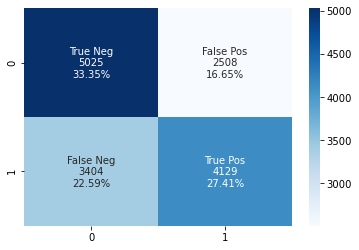

In [22]:
train_predictions = knn.predict_proba(scaled_train)[:,1]
train_predictions[train_predictions > 0.5] = 1
train_predictions[train_predictions <= 0.5] = 0
print('Train:')
knn_train_AUC, knn_train_accuracy, knn_train_precision, knn_train_recall, knn_train_cost = report(train_labels, train_predictions)
ensemble_train['KNN_train_predictions'] = train_predictions

Validation:
AUC:  0.5885916685566125
Accuracy:  0.6277789392989058
Precision:  0.16572160234132066
Recall:  0.5373665480427047
Confusion Matrix:
Cost:  1348.566450623737


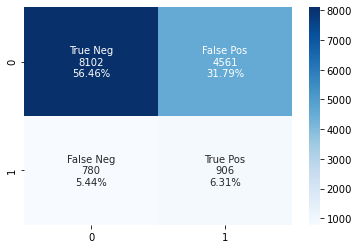

In [23]:
vd_predictions = knn.predict_proba(scaled_vd)[:,1]
vd_predictions[vd_predictions > 0.5] = 1
vd_predictions[vd_predictions <= 0.5] = 0
print('Validation:')
knn_vd_AUC, knn_vd_accuracy, knn_vd_precision, knn_vd_recall, knn_vd_cost = report(vd_labels, vd_predictions)
ensemble_validation['KNN_validation_predictions'] = vd_predictions

### Logistic Regression

In [70]:
from sklearn.linear_model import LogisticRegression
logistic_regression = LogisticRegression(penalty = 'l2', random_state=10, class_weight={0:0.6, 1:1})
logistic_regression.fit(scaled_train, train_labels)

C:\Users\ssear\anaconda3\envs\py36\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(class_weight={0: 0.6, 1: 1}, random_state=10)

Train:
AUC:  0.5959113235098898
Accuracy:  0.5959113235098898
Precision:  0.5617257582229817
Recall:  0.8728262312491704
Confusion Matrix:
Cost:  1521.7443249701314


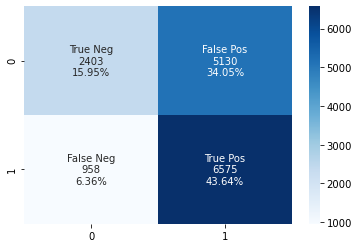

In [71]:
train_predictions = logistic_regression.predict_proba(scaled_train)[:,1]
train_predictions[train_predictions > 0.5] = 1
train_predictions[train_predictions <= 0.5] = 0
print('Train:')
lr_train_AUC, lr_train_accuracy, lr_train_precision, lr_train_recall, lr_train_cost = report(train_labels, train_predictions)
ensemble_train['LG_train_predictions'] = train_predictions

Validation:
AUC:  0.5808441552054449
Accuracy:  0.36817896717541293
Precision:  0.1409108602569093
Recall:  0.8588374851720048
Confusion Matrix:
Cost:  1333.9633423931982


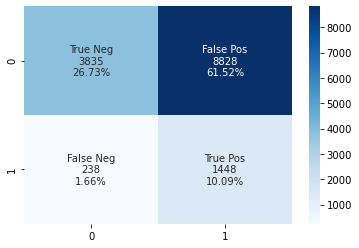

In [72]:
vd_predictions = logistic_regression.predict_proba(scaled_vd)[:,1]
vd_predictions[vd_predictions > 0.5] = 1
vd_predictions[vd_predictions <= 0.5] = 0
print('Validation:')
lr_vd_AUC, lr_vd_accuracy, lr_vd_precision, lr_vd_recall, lr_vd_cost = report(vd_labels, vd_predictions)
ensemble_validation['LG_validation_predictions'] = vd_predictions

### Stochastic Gradient Descent

In [229]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss = 'log', alpha = 0.3, random_state=10)
sgd.fit(scaled_train, train_labels)

SGDClassifier(alpha=0.3, loss='log', random_state=10)

Train:
AUC:  0.6212664277180407
Accuracy:  0.6212664277180406
Precision:  0.6360387192851824
Recall:  0.566971989911058
Confusion Matrix:
Cost:  3406.5525023231116


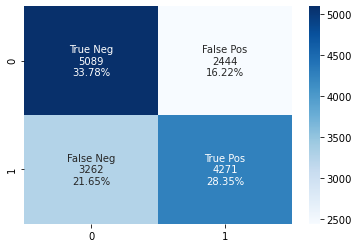

In [230]:
train_predictions = sgd.predict_proba(scaled_train)[:,1]
train_predictions[train_predictions > 0.5] = 1
train_predictions[train_predictions <= 0.5] = 0
print('Train:')
sgd_train_AUC, sgd_train_accuracy, sgd_train_precision, sgd_train_recall, sgd_train_cost = report(train_labels, train_predictions)
ensemble_train['SGD_train_predictions'] = train_predictions

Validation:
AUC:  0.6110948814645634
Accuracy:  0.6498013798871002
Precision:  0.18072289156626506
Recall:  0.5604982206405694
Confusion Matrix:
Cost:  1275.0658582479616


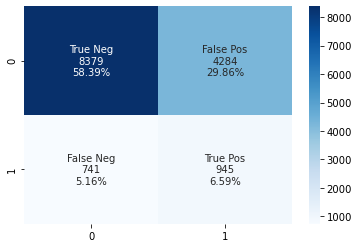

In [231]:
vd_predictions = sgd.predict_proba(scaled_vd)[:,1]
vd_predictions[vd_predictions > 0.5] = 1
vd_predictions[vd_predictions <= 0.5] = 0
print('Validation:')
sgd_vd_AUC, sgd_vd_accuracy, sgd_vd_precision, sgd_vd_recall, sgd_vd_cost = report(vd_labels, vd_predictions)
ensemble_validation['SGD_validation_predictions'] = vd_predictions

### Naive Bayes

In [76]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(scaled_train, train_labels)

GaussianNB()

Train:
AUC:  0.5065047125979025
Accuracy:  0.5065047125979025
Precision:  0.5033215835140998
Recall:  0.985663082437276
Confusion Matrix:
Cost:  968.887561396522


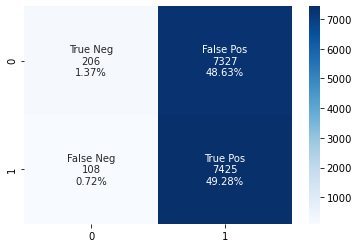

In [77]:
train_predictions = nb.predict_proba(scaled_train)[:,1]
train_predictions[train_predictions > 0.5] = 1
train_predictions[train_predictions <= 0.5] = 0
print('Train:')
nb_train_AUC, nb_train_accuracy, nb_train_precision, nb_train_recall, nb_train_cost = report(train_labels, train_predictions)
ensemble_train['NB_train_predictions'] = train_predictions

Validation:
AUC:  0.5028890878601401
Accuracy:  0.13666457592863615
Precision:  0.11811304596060519
Recall:  0.9816132858837485
Confusion Matrix:
Cost:  1564.0016725904245


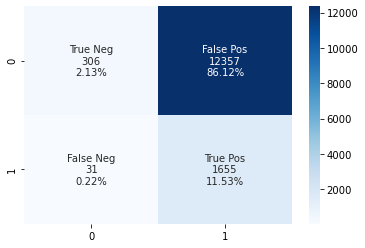

In [78]:
vd_predictions = nb.predict_proba(scaled_vd)[:,1]
vd_predictions[vd_predictions > 0.5] = 1
vd_predictions[vd_predictions <= 0.5] = 0
print('Validation:')
nb_vd_AUC, nb_vd_accuracy, nb_vd_precision, nb_vd_recall, nb_vd_cost = report(vd_labels, vd_predictions)
ensemble_validation['NB_validation_predictions'] = vd_predictions

### Decision Tree Classifier

In [79]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth = 10, random_state = 10)
dt.fit(scaled_train, train_labels)

DecisionTreeClassifier(max_depth=10, random_state=10)

Train:
AUC:  0.6667994159033586
Accuracy:  0.6667994159033586
Precision:  0.6928626247122026
Recall:  0.599230054427187
Confusion Matrix:
Cost:  3121.9553962564714


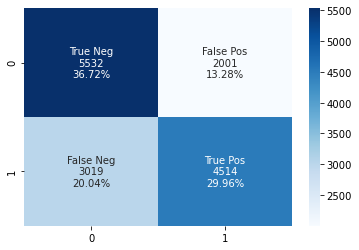

In [80]:
train_predictions = dt.predict_proba(scaled_train)[:,1]
train_predictions[train_predictions > 0.5] = 1
train_predictions[train_predictions <= 0.5] = 0
print('Train:')
dt_train_AUC, dt_train_accuracy, dt_train_precision, dt_train_recall, dt_train_cost = report(train_labels, train_predictions)
ensemble_train['DTC_train_predictions'] = train_predictions

Validation:
AUC:  0.6035741616158039
Accuracy:  0.6564917415847794
Precision:  0.17859266600594648
Recall:  0.5344009489916963
Confusion Matrix:
Cost:  1301.8551815457524


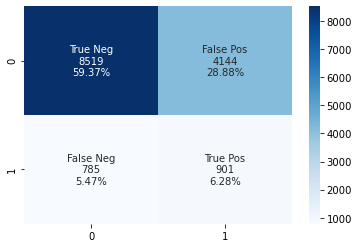

In [81]:
vd_predictions = dt.predict_proba(scaled_vd)[:,1]
vd_predictions[vd_predictions > 0.5] = 1
vd_predictions[vd_predictions <= 0.5] = 0
print('Validation:')
dt_vd_AUC, dt_vd_accuracy, dt_vd_precision, dt_vd_recall, dt_vd_cost = report(vd_labels, vd_predictions)
ensemble_validation['DTC_validation_predictions'] = vd_predictions

### Cost Sensitive Random Forest

In [147]:
cost_matrix = np.array([[15, 50, 0, 0]])
for i in range(len(train_labels)-1):
    cost_matrix = np.append(cost_matrix, [[15, 50, 0, 0]], axis=0)
cost_matrix.shape

(15066, 4)

In [148]:
train_labels.shape

(15066,)

In [149]:
from costcla.models import CostSensitiveRandomForestClassifier

CSRandomForest = CostSensitiveRandomForestClassifier(combination = 'weighted_voting', n_estimators = 10)
CSRandomForest.fit(scaled_train, train_labels, cost_matrix)

CostSensitiveRandomForestClassifier(combination='weighted_voting',
                                    max_features=1.0, n_estimators=10, n_jobs=1,
                                    pruned=False, verbose=False)

Train:
AUC:  0.5
Accuracy:  0.5
Precision:  0.0
Recall:  0.0
Confusion Matrix:
Cost:  7200.0


C:\Users\ssear\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


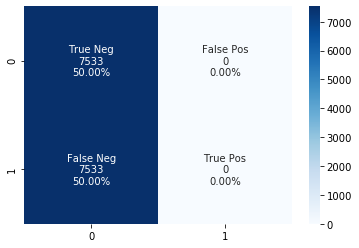

In [150]:
train_predictions = CSRandomForest.predict_proba(scaled_train)[:,1]
train_predictions[train_predictions > 0.5] = 1
train_predictions[train_predictions <= 0.5] = 0
print('Train:')
CSRandomForest_train_AUC, CSRandomForest_train_accuracy, CSRandomForest_train_precision, CSRandomForest_train_recall, CSRandomForest_train_cost = report(train_labels, train_predictions)
ensemble_train['CSRandomForest_train_predictions'] = train_predictions

Validation:
AUC:  0.5
Accuracy:  0.8825005226845076
Precision:  0.0
Recall:  0.0
Confusion Matrix:
Cost:  1691.99247334309


C:\Users\ssear\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


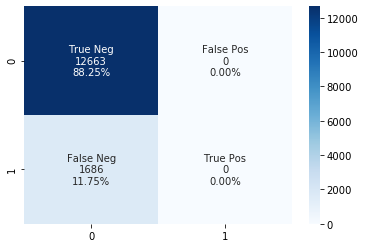

In [151]:
vd_predictions = CSRandomForest.predict_proba(scaled_vd)[:,1]
vd_predictions[vd_predictions > 0.50] = 1
vd_predictions[vd_predictions <= 0.50] = 0
print('Validation:')
CSRandomForest_vd_AUC, CSRandomForest_vd_accuracy, CSRandomForest_vd_precision, CSRandomForest_vd_recall, CSRandomForest_vd_cost = report(vd_labels, vd_predictions)
ensemble_validation['CSRandomForest_validation_predictions'] = vd_predictions

### Random Forest

In [211]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(min_impurity_decrease=0.00001, max_depth=16, random_state = 10)
rf.fit(scaled_train, train_labels)

RandomForestClassifier(max_depth=16, min_impurity_decrease=1e-05,
                       random_state=10)

Train:
AUC:  0.8469401300942518
Accuracy:  0.846940130094252
Precision:  0.8660876873511696
Recall:  0.8207885304659498
Confusion Matrix:
Cost:  1403.2709411920882


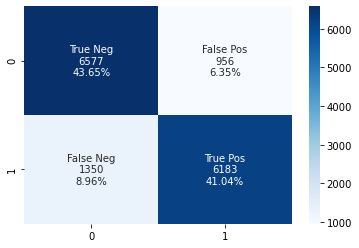

In [212]:
train_predictions = rf.predict_proba(scaled_train)[:,1]
train_predictions[train_predictions > 0.5] = 1
train_predictions[train_predictions <= 0.5] = 0
print('Train:')
rf_train_AUC, rf_train_accuracy, rf_train_precision, rf_train_recall, rf_train_cost = report(train_labels, train_predictions)
ensemble_train['RF_train_predictions'] = train_predictions

Validation:
AUC:  0.6268882245272536
Accuracy:  0.6359328176179525
Precision:  0.18478260869565216
Recall:  0.6150652431791221
Confusion Matrix:
Cost:  1218.8375496550282


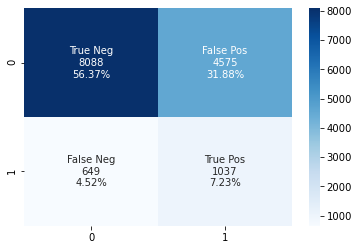

In [213]:
vd_predictions = rf.predict_proba(scaled_vd)[:,1]
vd_predictions[vd_predictions > 0.50] = 1
vd_predictions[vd_predictions <= 0.50] = 0
print('Validation:')
rf_vd_AUC, rf_vd_accuracy, rf_vd_precision, rf_vd_recall, rf_vd_cost = report(vd_labels, vd_predictions)
ensemble_validation['RF_validation_predictions'] = vd_predictions

### Gradient Boosting Classifier

In [256]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(n_estimators=300, learning_rate=1.0, random_state=42)
gbc.fit(scaled_train, train_labels)

GradientBoostingClassifier(learning_rate=1.0, n_estimators=300, random_state=42)

Train:
AUC:  0.7926456922872694
Accuracy:  0.7926456922872693
Precision:  0.7979456683335586
Recall:  0.7837514934289128
Confusion Matrix:
Cost:  1733.618744192221


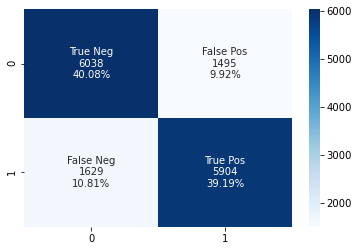

In [257]:
train_predictions = gbc.predict_proba(scaled_train)[:,1]
train_predictions[train_predictions > 0.5] = 1
train_predictions[train_predictions <= 0.5] = 0
print('Train:')
gbc_train_AUC, gbc_train_accuracy, gbc_train_precision, gbc_train_recall, gbc_train_cost = report(train_labels, train_predictions)
ensemble_train['GBC_train_predictions'] = train_predictions

Validation:
AUC:  0.5857345481820969
Accuracy:  0.5955118823611402
Precision:  0.1596694214876033
Recall:  0.5729537366548043
Confusion Matrix:
Cost:  1353.2315840825145


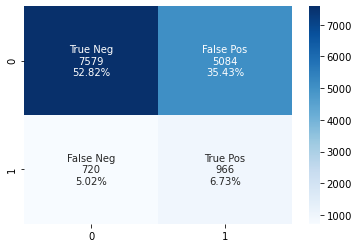

In [258]:
vd_predictions = gbc.predict_proba(scaled_vd)[:,1]
vd_predictions[vd_predictions > 0.5] = 1
vd_predictions[vd_predictions <= 0.5] = 0
print('Validation:')
gbc_vd_AUC, gbc_vd_accuracy, gbc_vd_precision, gbc_vd_recall, gbc_vd_cost = report(vd_labels, vd_predictions)
ensemble_validation['GBC_validation_predictions'] = vd_predictions

### Ensemble

In [88]:
ensemble_train['Avg_All'] = ensemble_train[['KNN_train_predictions', 'LG_train_predictions',\
                                           'SGD_train_predictions', \
                                           'DTC_train_predictions', 'GBC_train_predictions']].mean(axis=1)
ensemble_train['Avg_All'] = ensemble_train['Avg_All'].round(0)

Training Data
AUC:  0.663878932696137
Accuracy:  0.663878932696137
Precision:  0.6627125345986556
Recall:  0.667463162086818
Confusion Matrix:
Cost:  2696.6029470330545


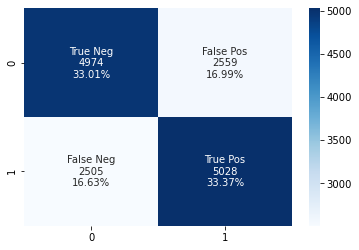

In [89]:
print('Training Data')
ensemble_train_AUC, ensemble_train_accuracy, ensemble_train_precision, ensemble_train_recall, ensemble_train_cost\
= report(ensemble_train.Truth, ensemble_train.Avg_All)

In [90]:
ensemble_train.to_excel('train__ensemble_labels.xlsx')

In [91]:
ensemble_validation['Avg_All'] = ensemble_validation[['KNN_validation_predictions', 'LG_validation_predictions',\
                                           'SGD_validation_predictions',\
                                           'DTC_validation_predictions', 'GBC_validation_predictions']].mean(axis=1)
ensemble_validation['Avg_All'] = ensemble_validation['Avg_All'].round(0)

Validation Data
AUC:  0.6207025511880242
Accuracy:  0.6104955049132343
Precision:  0.17695745737460686
Recall:  0.6340450771055753
Confusion Matrix:
Cost:  1235.9718447278556


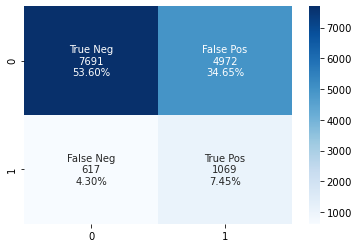

In [92]:
print('Validation Data')
ensemble_vd_AUC, ensemble_vd_accuracy, ensemble_vd_precision, ensemble_vd_recall, ensemble_vd_cost\
= report(ensemble_validation.Truth, ensemble_validation.Avg_All)

In [93]:
ensemble_validation.to_excel('validation__ensemble_labels.xlsx')

# Compare Results

In [259]:
models = ['KNN', 'LogReg', 'SGD', 'NB', 'DTC', 'RF', 'GBC', 'Ensemble']
train_auc = [knn_train_AUC, lr_train_AUC, sgd_train_AUC, nb_train_AUC, dt_train_AUC, rf_train_AUC, gbc_train_AUC, ensemble_train_AUC]
train_accuracy = [knn_train_accuracy, lr_train_accuracy, sgd_train_accuracy, nb_train_accuracy, dt_train_accuracy, rf_train_accuracy, gbc_train_accuracy, ensemble_train_accuracy]
train_precision = [knn_train_precision, lr_train_precision, sgd_train_precision, nb_train_precision, dt_train_precision, rf_train_precision, gbc_train_precision, ensemble_train_precision]
train_recall = [knn_train_recall, lr_train_recall, sgd_train_recall, nb_train_recall, dt_train_recall, rf_train_recall, gbc_train_recall, ensemble_train_recall]
train_cost = [knn_train_cost, lr_train_cost, sgd_train_cost, nb_train_cost, dt_train_cost, rf_train_cost, gbc_train_cost, ensemble_train_cost]
vd_auc = [knn_vd_AUC, lr_vd_AUC, sgd_vd_AUC, nb_vd_AUC, dt_vd_AUC, rf_vd_AUC, gbc_vd_AUC, ensemble_vd_AUC]
vd_accuracy = [knn_vd_accuracy, lr_vd_accuracy, sgd_vd_accuracy, nb_vd_accuracy, dt_vd_accuracy, rf_vd_accuracy, gbc_vd_accuracy, ensemble_vd_accuracy]
vd_precision = [knn_vd_precision, lr_vd_precision, sgd_vd_precision, nb_vd_precision, dt_vd_precision, rf_vd_precision, gbc_vd_precision, ensemble_vd_precision]
vd_recall = [knn_vd_recall, lr_vd_recall, sgd_vd_recall, nb_vd_recall, dt_vd_recall, rf_vd_recall, gbc_vd_recall, ensemble_vd_recall]
vd_cost = [knn_vd_cost, lr_vd_cost, sgd_vd_cost, nb_vd_cost, dt_vd_cost, rf_vd_cost, gbc_vd_cost, ensemble_vd_cost]

In [260]:
results_df = pd.DataFrame({'Model':models, 'Train AUC': train_auc, 'Train Accuracy': train_accuracy,\
                           'Train Precision': train_precision, 'Train Recall': train_recall,'Train Cost': train_cost,\
                           'Validation AUC': vd_auc, 'Validation Accuracy': vd_accuracy,\
                           'Validation Precision': vd_precision, 'Validation Recall': vd_recall,\
                           'Validation Cost': vd_cost})

In [261]:
results_df.sort_values(by = 'Validation Cost', ascending=True)

,Model,Train AUC,Train Accuracy,Train Precision,Train Recall,Train Cost,Validation AUC,Validation Accuracy,Validation Precision,Validation Recall,Validation Cost
5,RF,0.846940,0.846940,0.866088,0.820789,1403.270941,0.626888,0.635933,0.184783,0.615065,1218.837550
7,Ensemble,0.663879,0.663879,0.662713,0.667463,2696.602947,0.620703,0.610496,0.176957,0.634045,1235.971845
2,SGD,0.621266,0.621266,0.636039,0.566972,3406.552502,0.611095,0.649801,0.180723,0.560498,1275.065858
4,DTC,0.666799,0.666799,0.692863,0.599230,3121.955396,0.603574,0.656492,0.178593,0.534401,1301.855182
1,LogReg,0.595911,0.595911,0.561726,0.872826,1521.744325,0.580844,0.368179,0.140911,0.858837,1333.963342
0,KNN,0.607593,0.607593,0.622118,0.548122,3549.836718,0.588592,0.627779,0.165722,0.537367,1348.566451
6,GBC,0.792646,0.792646,0.797946,0.783751,1733.618744,0.585735,0.595512,0.159669,0.572954,1353.231584
3,NB,0.506505,0.506505,0.503322,0.985663,968.887561,0.502889,0.136665,0.118113,0.981613,1564.001673
